In [1]:
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt

# Quasi-continuous BN

aGrUM can not (for now) deal with continuous variables. However, a discrete variable with a large enough domain size is an approximation of such variables.

In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

#nbr of states for quasi continuous variables. You can change the value 
#but be carefull of the quadratic behaviour of both memory and time complexity
#in this example.
NB=300 

In [3]:
bn=gum.BayesNet("Quasi-Continuous")
a=bn.add(gum.LabelizedVariable("A","A binary variable",2))
b=bn.add(gum.RangeVariable("B","A range variable",0,NB-1))
bn.addArc(a,b)
print(bn)
gnb.showBN(bn)

BN{nodes: 2, arcs: 1, domainSize: 600, parameters: 602, compression ratio: -0% }


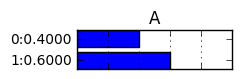

In [4]:
bn.cpt(a)[:]=[0.4, 0.6]
gnb.showProba(bn.cpt(a))

## CPT for quasi-continuous variables (with parents)

Using python (and scipy), it is easy to find pdf for continuous variable

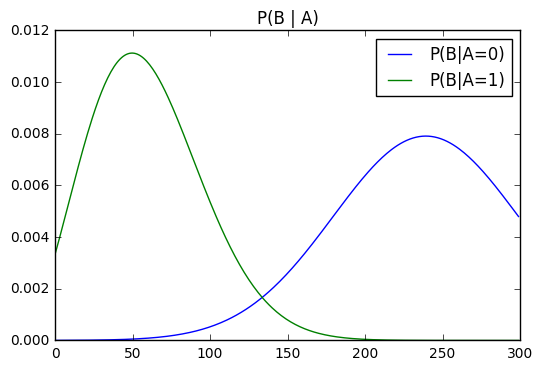

In [5]:
# we truncate a pdf, so we need to normalize 
def normalize(rv,vmin,vmax,size):
    pdf=rv.pdf(linspace(vmin,vmax,size))
    return (pdf/sum(pdf))

from scipy.stats import norm,maxwell

plot(normalize(norm(),-4,1,NB)) # P(B|A=0) is a Gaussian distribution
plot(normalize(maxwell(),0.5,6,NB))  # P(B|A=1) is a Maxwell-Boltzmann distribution
title("P(B | A)")
legend(["P(B|A=0)","P(B|A=1)"],loc='best')

bn.cpt(b)[{'A':0}]=normalize(norm(),-4,1,NB)
bn.cpt(b)[{'A':1}]=normalize(maxwell(),0.5,6,NB)

## Inference

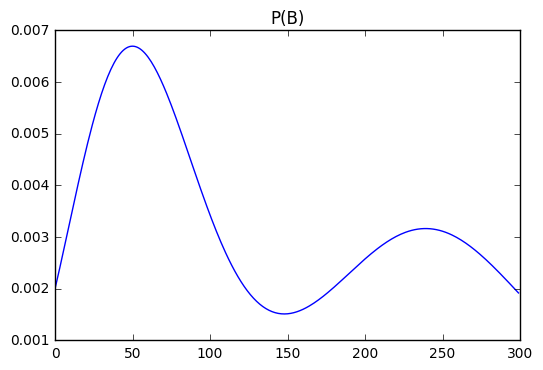

In [6]:
ie=gum.LazyPropagation(bn)
ie.makeInference()
plot(ie.posterior(b)[:]) # the posterior for B
t=title("P(B)")

## Quasi-continuous variable with quasi-continuous parent

In [7]:
c=bn.add(gum.RangeVariable("C","Another quasi continuous variable",0,NB-1))
bn.addArc(b,c)
gnb.showBN(bn) # B and C are quasi-continouous

Even if this BN is quite small (and linear), the size of nodes $B$ et $C$ are rather big and creates a complex model (NBxNB parameters in $P(C|B)$).

In [8]:
print("nombre de paramètres du bn : {0}".format(bn.dim()))
print("domaine du bn : 10^{0}".format(bn.log10DomainSize()))

nombre de paramètres du bn : 90299
domaine du bn : 10^5.2552725051033065


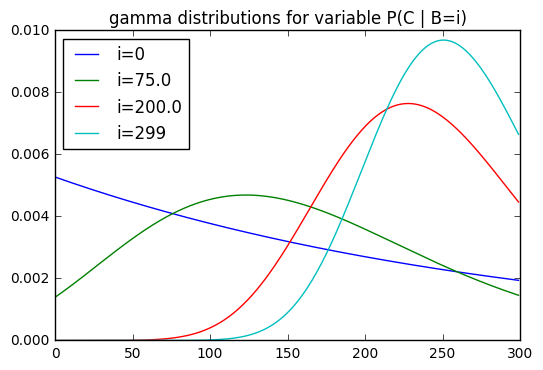

In [9]:
from scipy.stats import gamma
# cpt(c) is NB x NB matrix !
l=[]
for i in range(NB):
    # the size and the parameter of gamma depends on the parent value
    k=(i*30.0)/NB
    l.append(normalize(gamma(k+1),4,5+k,NB))

bn.cpt(c)[:]=l

#for instance 
plot(bn.cpt(c)[{'B':0}])
plot(bn.cpt(c)[{'B':NB//4}])
plot(bn.cpt(c)[{'B':NB*2//3}])
plot(bn.cpt(c)[{'B':NB-1}])
title("gamma distributions for variable P(C | B=i)")
legend(["i=0","i={0}".format(NB/4),"i={0}".format(2*NB/3),"i={0}".format(NB-1)],
       loc='best');

# Inference in quasi-continuous BN

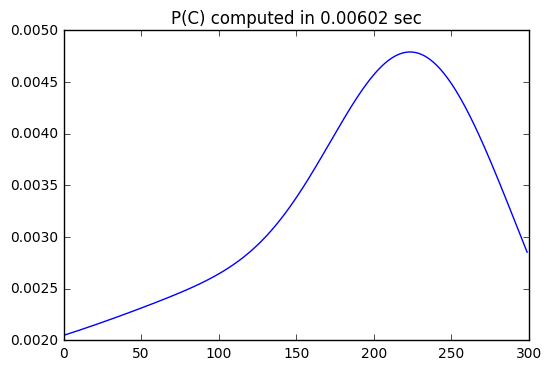

In [16]:
import time

ts = time.time()
ie=gum.LazyPropagation(bn)
ie.makeInference()
te=time.time()

plot(ie.posterior(c)[:])
t=title("P(C) computed in {0:2.5f} sec".format(te-ts))

## Changing prior

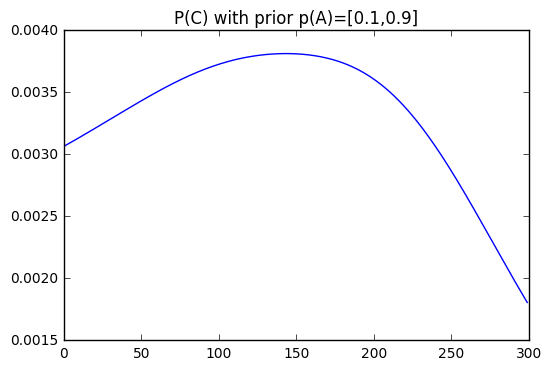

In [11]:
bn.cpt(a)[:]=[0.1,0.9]
ie=gum.LazyPropagation(bn)
ie.makeInference()
plot(ie.posterior(c)[:])
t=title("P(C) with prior p(A)=[0.1,0.9]")

# inference with evidence

We want to compute 
<ul><li>
$P(A | C=\frac{2*NB}{3})$ 
</li><li>
$P(B | C=\frac{2*NB}{3})$
</li></ul>

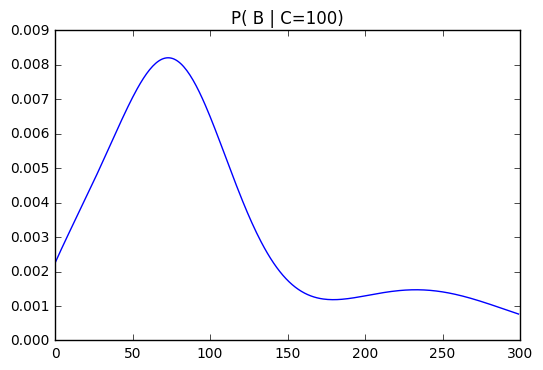

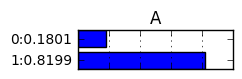

In [12]:
ie=gum.LazyPropagation(bn)
ie.setEvidence({'C':NB*2//3})
ie.makeInference()
plot(ie.posterior(b)[:])
title("P( B | C={0})".format(NB//3))
gnb.showProba(ie.posterior(a))

## Multiple inference : MAP DECISION between Gaussian and Maxwell-Boltzman distributions

What is the behaviour of $P(A | B=i)$&nbsp;&nbsp; when $i$ varies ? I.e. we perform a MAP decision between the two models ($A=0$&nbsp; for the Gaussian distribution and $A=1$&nbsp; for the Maxwell-Boltzman distribution).

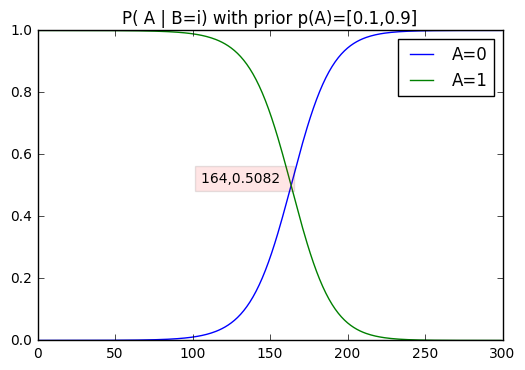

In [13]:
bn.cpt(a)[:]=[0.1, 0.9]
ie=gum.LazyPropagation(bn)
p0=[]
p1=[]
for i in range(300):
    ie.setEvidence({'B':i})
    ie.makeInference()    
    p0.append(ie.posterior(a)[0])    
    p1.append(ie.posterior(a)[1])
plot(p0)
plot(p1)
title("P( A | B=i) with prior p(A)=[0.1,0.9]")
legend(["A=0","A=1"],loc='best')
inters=(transpose(p0)<transpose(p1)).argmin()
text(inters-2,p0[inters],
     "{0},{1:5.4f}  ".format(inters,p0[inters]),
     bbox=dict(facecolor='red', alpha=0.1),ha='right');

i.e. if $i<164$ then $A=1$ else $A=0$

### Changing the prior $P(A)$

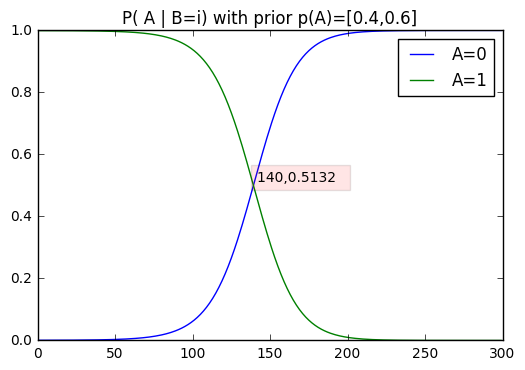

In [14]:
bn.cpt(a)[:]=[0.4, 0.6]
ie=gum.LazyPropagation(bn)
p0=[]
p1=[]
for i in range(300):
    ie.setEvidence({'B':i})
    ie.makeInference()    
    p0.append(ie.posterior(a)[0])    
    p1.append(ie.posterior(a)[1])
plot(p0)
plot(p1)
title("P( A | B=i) with prior p(A)=[0.4,0.6]")
legend(["A=0","A=1"],loc='best')
inters=(transpose(p0)<transpose(p1)).argmin()
text(inters+1.5,p0[inters],
     "{0},{1:5.4f}  ".format(inters,p0[inters]),
     bbox=dict(facecolor='red', alpha=0.1));

ie. with $p(A)=[0.4,0.6]$, if $i<140$ then $A=1$ else $A=0$.